In [1]:
using StarStats

Load the entire database of grids 

In [2]:
using Printf
using BenchmarkTools
function path_constructor(strings::Vector{String})
    DATA_FOLDER = ENV["STARSTATS_TEST_DATA_FOLDER"]
    return DATA_FOLDER*"/LMC/LMC_$(strings[1])_$(strings[2])_$(strings[3]).track.gz"
end
masses = [@sprintf("%.3f", x) for x in range(0.9,2.1,step=0.025)]
rotation = [@sprintf("%.2f", x) for x in range(0.0,0.9,step=0.1)]
overshoot = [@sprintf("%.2f", x) for x in range(0.5,4.5,step=0.5)]
#change name grid to e.g. star_grid
grid = ModelDataGrid([rotation,masses,overshoot],
    [:rotation,:logM,:overshoot])
#@benchmark 
load_grid(grid,path_constructor,gz_dataframe_loader_with_Teff_and_star_age_fix); 
compute_distances_and_EEPs(grid)

In [3]:
observable_names = [:logTeff, :logL, :vrot]
observable_values = [4.51974, 4.289877, 70.7195]
observable_errors = [0.2, 0.2, 10]



3-element Vector{Float64}:
  0.2
  0.2
 10.0

In [4]:
using Turing, Distributions

@model function star_model(logTeff_obs, logTeff_err, logL_obs, logL_err, vrot_obs, vrot_err, grid)
  x ~ Uniform(0,3)
  logM ~ Uniform(0.9, 1.5)
  rotation ~ Uniform(0,0.9)
  overshoot ~ Uniform(0.5,1.5)
  logTeff = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:logTeff,x)
  logL = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:logL,x)
  vrot = interpolate_grid_quantity(grid,[rotation, logM, overshoot],:vrot,x)
  

  logTeff_obs ~ Normal(logTeff, logTeff_err)
  logL_obs ~ Normal(logL, logL_err)
  vrot_obs ~ Normal(vrot, vrot_err)
  return logTeff_obs, logL_obs, vrot_obs
end

star_model (generic function with 2 methods)

In [5]:
using Logging
Logging.disable_logging(Logging.Warn)
## Here needs more analysis for optimization
num_chains=4

observed_star_model = star_model(4.51974, 0.2, 4.289877, 0.2, 70.7195, 20, grid)
star_chains = mapreduce(c -> sample(observed_star_model, NUTS(500,0.9), 20000;stream=false, progress=true), chainscat, 1:num_chains)

Chains MCMC chain (20000×16×4 Array{Float64, 3}):

Iterations        = 501:1:20500
Number of chains  = 4
Samples per chain = 20000
Wall duration     = 101.34 seconds
Compute duration  = 95.02 seconds
parameters        = x, logM, rotation, overshoot
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           x    1.0414    0.6294     0.0022    0.0048   17432.3589    1.0003   ⋯
        logM    1.0863    0.0835     0.0003    0.0005   24619.1212    1.0002   ⋯
    rotation    0.1218    0.0490     0.0002    0.0005   10558.2463    1.0009   ⋯
   overshoot    0.9935    0.2895     0.0010    0.0015   40321.3079    1.0000   ⋯
                                        

In [ ]:
#histogram(star_chains[:x],alpha=0.5,nbins=30)

In [6]:
#logM = star_chains[
 
logM = star_chains[:,:logM, :1].data
append!(logM,star_chains[:,:logM, :2].data)
append!(logM,star_chains[:,:logM, :3].data)
append!(logM,star_chains[:,:logM, :4].data)
@show length(logM)

rotation = star_chains[:,:rotation, :1].data
append!(rotation,star_chains[:,:rotation, :2].data)
append!(rotation,star_chains[:,:rotation, :3].data)
append!(rotation,star_chains[:,:rotation, :4].data)

overshoot= star_chains[:,:overshoot, :1].data
append!(overshoot,star_chains[:,:overshoot, :2].data)
append!(overshoot,star_chains[:,:overshoot, :3].data)
append!(overshoot,star_chains[:,:overshoot, :4].data)

x= star_chains[:,:x, :1].data
append!(x,star_chains[:,:x, :2].data)
append!(x,star_chains[:,:x, :3].data)
append!(x,star_chains[:,:x, :4].data)


##problem: how to get dtdx --- below is messed up 
dtdx=zeros(length(logM))
for i in 1:length(logM)
    dtdx[i]= interpolate_grid_quantity(grid,[rotation[i], logM[i], overshoot[i]],:dtdx,x[i])
    #interpolate_grid_quantity.(Ref(grid),Ref([0.13,1.21,1.05]),:logTeff, xvals)
end


length(logM) = 80000


In [7]:
using QuadGK
function chain_credible_interval(values, fraction,num_points,weights)
    maxval= maximum(logM)
    minval = minimum(logM)
    my_kde = kde(logM, weights=weights)
    kde_function = x-> pdf(my_kde, x)
    
    integral = quadgk(kde_function,minval,maxval, rtol=1e-8)[1]
    
    xvalues = collect(LinRange(minval,maxval,num_points))
    yvalues = kde_function(xvalues)
    max_valy = findmax(yvalues)
    maxx = xvalues[max_valy[2]]
    maxy = max_valy[1]
    
    function kde_function2(x, kde_function, bound)
        value = kde_function(x)
        if value>bound
            return value
        else
            return 0
        end
    end
    minbound = 0
    maxbound = maxy
    newbound = 0
    for i in 1:15
        newbound = 0.5*(minbound+maxbound)
        integral2 = quadgk(x -> kde_function2(x,kde_function,newbound), minval, maxval, rtol=1e-8)[1]
        newfraction = integral2/integral
        if newfraction>fraction
            minbound = newbound
        else
            maxbound = newbound
        end
    end
    filtered_xvalues = xvalues[yvalues.>newbound]
    return ([maximum(filtered_xvalues), maxx, minimum(filtered_xvalues)], newbound)
end

chain_credible_interval (generic function with 1 method)

In [ ]:
num_points = 10000
values = logM
fraction = 0.9


CI = chain_credible_interval(values, fraction, num_points,dtdx)
#@show dtdx

In [ ]:
observable_names = [:logTeff, :logL, :vrot]
observable_values = [4.51974, 4.289877, 70.7195]
observable_errors = [0.2, 0.2, 20]
# potentially parallelize this
grid_likelihood = ModelDataGridLikelihood(grid, observable_names, observable_values, observable_errors);
CI2 = credible_interval(grid_likelihood, :logM,0.9,1_000_000)

In [ ]:
#using Plots
plot()
ml= marginalized_likelihood(grid_likelihood,[:logM])
plot!(grid.input_values[2], ml./maximum(ml))
hline!([CI2[2]/maximum(ml)])
vline!(CI2[1])

my_kde = kde(logM, weights=dtdx)
plot!(x->pdf(my_kde,x)/pdf(my_kde,CI[1][2]), xrange=[0.8, 2.1])

hline!([CI[2]/pdf(my_kde,CI[1][2])])
vline!(CI[1])

To do :

1. MCMC code into its own  file within package
    - make sampling code work with arbitrary observables
    - make credible interval code flexible 
    - optimize the credible interval code 
    - create  pretty corner plots 
    - 
2. grid computed 
3. create simple interpolation interface 
4. change longM with values in credible interval bla



In [ ]:
using StatsPlots
using HCubature
using Interpolations
using KernelDensity
plot()
#histogram2d(logM, rotation)
my_kde2d = kde((logM,rotation),weights=dtdx)
kde_function2d = x-> pdf(my_kde2d, x[1],x[2])
#kde_function2d = (x,y)-> pdf(my_kde2d, x,y)

contourf!(my_kde2d)



In [ ]:
my_kde2d = kde((logM,rotation),weights=dtdx)
kde_function2d =x-> pdf(my_kde2d, x[1],x[2]) #(x,y)-> pdf(my_kde2d, x,y) #
values1= logM
values2=rotation

maxval1 = maximum(values1)
minval1 = minimum(values1)
maxval2 = maximum(values2)
minval2 = minimum(values2)

steps = 100
my_x1 = LinRange(minval1, maxval1, steps)
my_x2 = LinRange(minval2, maxval2, steps)

evaluated_kde = zeros(steps, steps)
for i in 1:steps
    for j in 1:steps
        evaluated_kde[i,j] = kde_function2d((my_x1[i],my_x2[j]))
    end

 
end 

# a = (minval1, minval2)
# b = (maxval1, maxval2)

# integral = hcubature(kde_function2d,[0.9, 0.0],[1.2,0.4], rtol=1e-4,initdiv=1)
# @show integral
#kde_function2d

#

In [ ]:
@benchmark kde_function2d((my_x1[1],my_x2[2]))

In [ ]:
using StatsBase
h = fit(Histogram,(logM,rotation),weights(dtdx),nbins=100)

In [ ]:
y = diff(h.edges[1])/2 .+ h.edges[1][1:end-1]
x = diff(h.edges[2])/2 .+ h.edges[2][1:end-1]
heatmap(x, y, h.weights)



In [ ]:
using Interpolations
interpolator = interpolate((y,x), h.weights, Gridded(Linear()))
@show x
@show y



In [ ]:
@show a = (x[1], y[1])
@show b = (x[end], y[end])
integral = hcubature(x-> interpolator(x[2],x[1]),a,b, rtol=1e-6,initdiv=1)


In [49]:
using StatsBase
using CairoMakie
function get_2D_plot(grid,star_chains,fractions)

    f = Figure()
    axis1=Axis(f[1, 1])
    
    logM = star_chains[:,:logM, :1].data
    append!(logM,star_chains[:,:logM, :2].data)
    append!(logM,star_chains[:,:logM, :3].data)
    append!(logM,star_chains[:,:logM, :4].data)
    
    rotation = star_chains[:,:rotation, :1].data
    append!(rotation,star_chains[:,:rotation, :2].data)
    append!(rotation,star_chains[:,:rotation, :3].data)
    append!(rotation,star_chains[:,:rotation, :4].data)

    overshoot= star_chains[:,:overshoot, :1].data
    append!(overshoot,star_chains[:,:overshoot, :2].data)
    append!(overshoot,star_chains[:,:overshoot, :3].data)
    append!(overshoot,star_chains[:,:overshoot, :4].data)

    x= star_chains[:,:x, :1].data
    append!(x,star_chains[:,:x, :2].data)
    append!(x,star_chains[:,:x, :3].data)
    append!(x,star_chains[:,:x, :4].data)

    dtdx=zeros(length(logM))
    for i in 1:length(logM)
        dtdx[i]= interpolate_grid_quantity(grid,[rotation[i], logM[i], overshoot[i]],:dtdx,x[i])
    end

    h = fit(Histogram,(rotation,logM),weights(dtdx),nbins=100)
    x= h.edges[2][1:end-1].+(h.edges[2][2:end].-h.edges[2][1:end-1])./2
    y = h.edges[1][1:end-1].+(h.edges[1][2:end].-h.edges[1][1:end-1])./2
    
    
    integral = sum(h.weights)
    #smartely decide when the bisection is ended 
    heatmap!(axis1,y,x, h.weights)
    bounds =zeros(length(fractions))
    for (j,fraction) in enumerate(fractions)
        minbound = 0
        maxbound = maximum(h.weights)
        newbound = 0
        for i in 1:15
            newbound = 0.5*(minbound+maxbound)
            integral2 = sum(h.weights[h.weights.>newbound])
            newfraction = integral2/integral
            if newfraction>fraction
                minbound = newbound
            else
                maxbound = newbound
            end

        end
        bounds[j] = newbound
        
    end 
    #for bound in bounds
    @show bounds
    contour!(axis1,y,x, h.weights, levels=bounds,color=:black,linewidth=2)
    #end
    return f
end  

get_2D_plot (generic function with 1 method)

bounds = [8.215919783558714e8, 4.182964291991063e8]


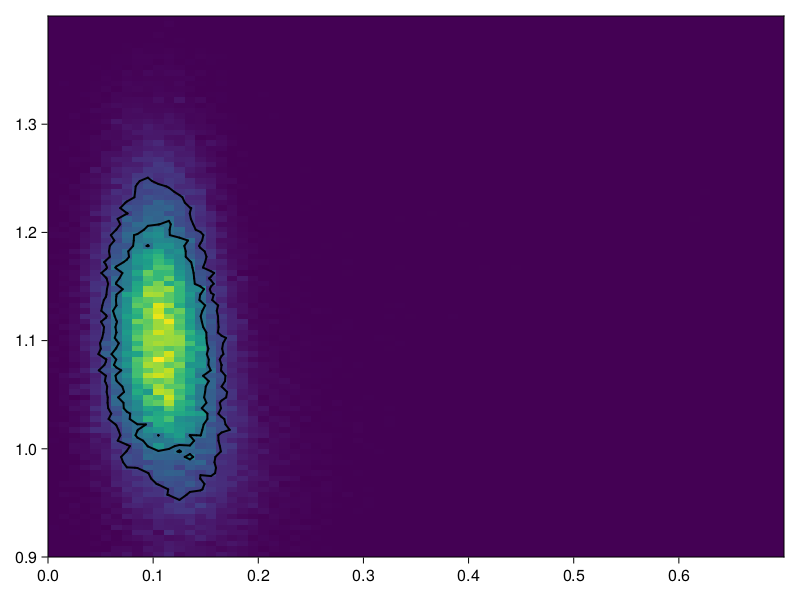

In [50]:

get_2D_plot(grid, star_chains,(0.6, 0.8))

In [ ]:
using QuadGK
using HCubature
function chain_credible_interval2d(values1,values2, fraction,num_points,weights)
    maxval1 = maximum(values1)
    minval1 = minimum(values1)
    maxval2 = maximum(values2)
    minval2 = minimum(values2)

    my_kde2d = kde((values1,values2),weights=dtdx)
    kde_function2d = (x,y)-> pdf(my_kde2d, x,y)
    
    a = [minval1, minval2]
    b = [maxval1, maxval2]
    integral = hcubature(my_kde2d, a, b; norm=norm, rtol=1e-8, atol=0, maxevals=typemax(Int), initdiv=1)[1]
    quadgk(kde_function2d,minval,maxval, rtol=1e-8)[1]
    
    xvalues = collect(LinRange(minval,maxval,num_points))
    yvalues = kde_function(xvalues)
    max_valy = findmax(yvalues)
    maxx = xvalues[max_valy[2]]
    maxy = max_valy[1]
    
    function kde_function2(x, kde_function, bound)
        value = kde_function(x)
        if value>bound
            return value
        else
            return 0
        end
    end
    minbound = 0
    maxbound = maxy
    newbound = 0
    for i in 1:15
        newbound = 0.5*(minbound+maxbound)
        integral2 = quadgk(x -> kde_function2(x,kde_function,newbound), minval, maxval, rtol=1e-8)[1]
        newfraction = integral2/integral
        if newfraction>fraction
            minbound = newbound
        else
            maxbound = newbound
        end
    end
    filtered_xvalues = xvalues[yvalues.>newbound]
    return ([maximum(filtered_xvalues), maxx, minimum(filtered_xvalues)], newbound)
end